# Thesis Hierarchical plots - 1try - Parameters for weights and threshold

1/X

Randomly varying 3 parameters:
- p / sparsity
- lambda / sigma_weights
- theta / threshold for second layer ReLU.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import scipy as sp
import scipy.stats as spst
import scipy.interpolate as spint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.utils import io
import progress
import collections
import cPickle as pickle

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa

import hierarchicalrandomnetwork

# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
import load_experimental_data

from plots_fitexperiment_papertheo import PlotsFitExperimentAllTPaperTheo
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2})

In [3]:
overwrite = False
cache_filename = ("/nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/"
                  "hierarchical_weights_plambdatheta_1try_repetitions10_270818/outputs/df_out.pkl")

if os.path.exists(cache_filename) and not overwrite:
    import reloader_hierarchical_weights_1try_270818 as rel
    generator_module = rel.generator_module
    dataset_infos = rel.dataset_infos
    df_all_fits = pd.read_pickle(cache_filename)
else:
    with io.capture_output(display=False, stdout=True) as captured:
        %run reloader_hierarchical_weights_1try_270818.py
        
    dataset_infos = data_pbs.dataset_infos

Reloader data generated from  generator_hierarchical_weights_1try_270818.py


In [4]:
dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', 
                label='thesis_' + dataset_infos['save_output_filename'])
dataio.make_link_output_to_dropbox(dropbox_current_experiment_folder='hierarchicalrandomnetwork_characterisation')

=== FileIO ready: /nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/hierarchical_weights_plambdatheta_1try_repetitions10_270818/outputs/thesis_hier_params-<module>-632908c0-50c6-43d2-942a-eb3ba90cc2ad ===
Doing dropbox symlink:  /nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/hierarchical_weights_plambdatheta_1try_repetitions10_270818/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/hierarchicalrandomnetwork_characterisation/hierarchical_weights_plambdatheta_1try_repetitions10_270818_outputs
Symlink failed:  /nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/hierarchical_weights_plambdatheta_1try_repetitions10_270818/outputs/ /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/code/git-bayesian-visual-working-memory/Experiments/hierarchicalrandomnetwork_characterisation/hierarchical_weights_plambdatheta_1tr

In [5]:
# Processing data 
def avg_axis(array_name, array, axis=None, out=None):
    if out is None:
        out = []
    out.append((array_name, np.mean(array, axis=axis)))
    return out

def process_inv_var(array_name, array):
    out = []
    avg_axis(array_name, array, out=out)
    avg_axis(array_name + "_stddev", (1./array)**0.5, out=out)
    return out
    
def process_marginal_fi(array_name, array):
    out = []
    
    # Marginal FI/Inv FI have (mean, std), just keep mean
    array = array[..., 0]
    avg_axis(array_name, array, out=out)
    
    if array_name.find('inv') > -1:
        avg_axis(array_name + "_stddev", (1.*array)**0.5, out=out)
    else:
        avg_axis(array_name + "_stddev", (1./array)**0.5, out=out)
    
    return out

def process_em_fits(array_name, array):
    out = []
    for col_i, colname in enumerate(
            ['kappa', 'target', 'nontargets', 'random', 'LL', 'bic']):
        out = avg_axis(array_name + "_" + colname, array[col_i], out=out)
        
    out = avg_axis(array_name + '_fidelity', 1./utils.kappa_to_stddev(array[0])**2., out=out)
    out = avg_axis(array_name + '_stddev', utils.kappa_to_stddev(array[0]), out=out)
    
    return out

def construct_pandas_dataframe_flat(data_pbs, pandas_columns_with_processing, num_repetitions, overwrite=False):    
    parameter_names_sorted = data_pbs.dataset_infos['parameters']
    num_samples = len(data_pbs.loaded_data['datasets_list'])
    pandas_column_data = collections.defaultdict(list)

    load_progress = progress.Progress(num_samples)
    for i in xrange(num_samples):
        # For every sample, need to add a row with all columns
        if i % (num_samples/10) == 0:
            print "{:.1f}% {}".format(load_progress.percentage(), load_progress.time_remaining_str())

        # Extract data
        for repet_i in xrange(num_repetitions):
            # Filter completed only
            repeats_completed = data_pbs.dict_arrays.values()[0]['repeats_completed'][i]
            if repeats_completed != (num_repetitions - 1):
                continue

            for result_array_name, result_processing in pandas_columns_with_processing:
                res_array = np.array(data_pbs.dict_arrays[result_array_name]['results_flat'][i])[..., repet_i]

                columns_data = result_processing['process'](result_processing['name'], res_array)
                for column_name, col_data in columns_data:
                    pandas_column_data[column_name].append(col_data)

            pandas_column_data['repet'].append(repet_i)
            for param_i, param_name in enumerate(parameter_names_sorted):
                pandas_column_data[param_name].append(
                    data_pbs.dict_arrays[result_array_name]['parameters_flat'][i][param_i])

        load_progress.increment()

    df_out = pd.DataFrame(pandas_column_data)
    return df_out

In [6]:
def remove_outliers(df, n_stddev=5):
    outliers = np.sum(np.abs(spst.zscore(df)) < n_stddev, axis=-1)
    return df[outliers >= outliers.max()]

def df_add_quantize_parameters(df, parameters, nQuantiles):
    param_qbins = dict()
    param_qbins_middle = dict()

    for param_name in parameters:
        param_factored, param_qbins[param_name] = pd.cut(df[param_name], nQuantiles, retbins=True, labels=False)
        param_qbins[param_name] = np.unique(param_qbins[param_name])
        param_qbins_middle[param_name] = ((param_qbins[param_name][:-1] + param_qbins[param_name][1:])/2.
                                         ).astype(df[param_name].dtype)
        df.loc[:, (param_name + "_qi")] = param_factored
    
    return df, param_qbins, param_qbins_middle

def filter_dataframe(df, parameters_values):
    filter_mask = None
    for key, value in parameters_values.iteritems():
        new_filter = (df[key] == value)
        if filter_mask is None:
            filter_mask = new_filter
        else:
            filter_mask = filter_mask & new_filter
    
    if filter_mask is None:
        return df
    else:
        return df[filter_mask]

def filter_quantized_param(df, target_parameters, param_qbins):
    quantized_parameters_targets = dict()
    
    for key, value in target_parameters.iteritems():
        target_qi = (np.digitize(value, param_qbins[key], right=False).item() - 1)
        quantized_parameters_targets[key + "_qi"] = target_qi
        
    return filter_dataframe(df, quantized_parameters_targets)

In [7]:
# Extract data
num_repetitions = generator_module.num_repetitions
parameter_names_sorted = dataset_infos['parameters']

if not os.path.exists(cache_filename) or overwrite:
    pandas_columns_with_processing = [
        ('result_all_precisions', dict(name='precision', process=process_inv_var)),
        ('result_FI_rc_curv', dict(name='fi_curv', process=process_inv_var)),
        ('result_em_fits', dict(name='emfit', process=process_em_fits)),
    ]

    df_all_fits = construct_pandas_dataframe_flat(data_pbs, pandas_columns_with_processing, num_repetitions)
    df_all_fits.to_pickle(cache_filename)
else:
    df_all_fits = pd.read_pickle(cache_filename)

In [22]:
# df_all_fits.loc[:, ('ratio_fi_fidelity')] = df_all_fits['fi_theo']/(2*df_all_fits['emfit_fidelity'])
# df_all_fits.loc[:, ('ratio_fi_fidelity_error')] = df_all_fits['ratio_fi_fidelity'] - 1.
# df_all_fits.loc[:, ('ratio_fi_stddev')] = df_all_fits['fi_theo_stddev']/(df_all_fits['emfit_stddev'])
# df_all_fits.loc[:, ('ratio_margfi_stddev')] = df_all_fits['inv_fi_marginal_stddev']/(df_all_fits['emfit_stddev'])

# Filter a bit
df_fits_filtered = df_all_fits.dropna()
df_fits_filtered = df_fits_filtered[df_fits_filtered['sparsity'] <= 1.]
# df_fits_filtered = df_fits_filtered[df_fits_filtered.M > 25]
# df_fits_filtered = df_fits_filtered[df_all_fits['inv_fi_marginal_stddev'] < 1.]

sparsity_space = np.sort(df_fits_filtered['sparsity'].unique())
sigma_weights_space = np.sort(df_fits_filtered['sigma_weights'].unique())
threshold_space = np.sort(df_fits_filtered['threshold'].unique())

In [23]:
# Remove outliers
df_fits_filtered = remove_outliers(df_fits_filtered, 5)

In [24]:
df_fits_filtered.describe()

,emfit_LL,emfit_bic,emfit_fidelity,emfit_kappa,emfit_nontargets,emfit_random,emfit_stddev,emfit_target,fi_curv,fi_curv_stddev,precision,precision_stddev,repet,sigma_weights,sparsity,threshold
count,44455.000000,44455.000000,44455.000000,44455.000000,44455.0,44455.000000,44455.000000,44455.000000,44455.000000,44455.000000,44455.000000,44455.000000,44455.000000,44455.000000,44455.000000,44455.000000
mean,-223.819101,468.831471,31.628072,32.135862,0.0,0.462147,0.186245,0.537853,112.072549,0.110982,1.031988,1.127005,4.498077,1.013554,0.542774,0.985403
std,80.441660,160.883319,11.695851,11.693223,0.0,0.185314,0.034616,0.185314,29.362829,0.014505,0.643519,0.340753,2.872047,0.574298,0.266714,0.569351
min,-367.106099,-25.312971,5.590152,6.137224,0.0,0.090721,0.067720,0.023586,40.420250,0.073293,0.129289,0.477762,0.000000,0.000572,0.045531,0.000335
25%,-293.013104,344.219859,24.420310,24.929181,0.0,0.307861,0.164168,0.391308,89.249073,0.100255,0.539206,0.857099,2.000000,0.528316,0.313862,0.488702
50%,-227.136055,475.465379,30.375782,30.882856,0.0,0.439607,0.181441,0.560393,111.031330,0.109174,0.867433,1.073698,4.000000,1.027514,0.538460,0.982910
75%,-161.513295,607.219477,37.104345,37.610103,0.0,0.608692,0.202360,0.692139,132.497372,0.120033,1.361251,1.361829,7.000000,1.503041,0.776679,1.463328
max,23.253120,755.405468,218.054684,218.555644,0.0,0.976414,0.422949,0.909279,247.580890,0.182597,4.381034,2.781118,9.000000,1.998520,0.999996,1.998640


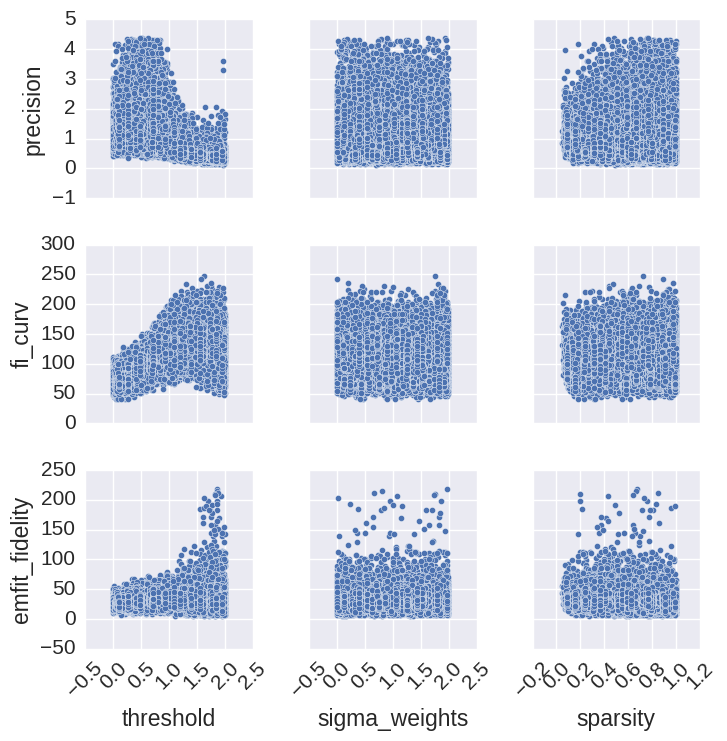

In [25]:
# Cross-correlation plots
g = sns.pairplot(
    df_fits_filtered,
    x_vars=parameter_names_sorted,
    y_vars=['precision', 'fi_curv', 'emfit_fidelity']
)
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

### Using sparsity < 0.07 messed some things...

dropna() removes them.

==> It was because some empty weight rows were giving nans...

In [26]:
# df_fits_filtered.loc[:, 'bad_param'] = np.isinf(df_fits_filtered.emfit_bic)
# sns.pairplot(df_fits_filtered, vars=parameter_names_sorted, hue="bad_param")

In [27]:
# print "Bad:"
# print df_fits_filtered[df_fits_filtered.bad_param].sparsity.describe()

# print "\nGood:"
# print df_fits_filtered[~df_fits_filtered.bad_param].sparsity.describe()

# """
# Bad:
# count    3987.000000
# mean        0.046505
# std         0.031094
# min         0.000071
# 25%         0.021472
# 50%         0.042941
# 75%         0.068627
# max         0.179678
# Name: sparsity, dtype: float64

# Good:
# count    96013.000000
# mean         1.048189
# std          0.550482
# min          0.045531
# 25%          0.569647
# 50%          1.052955
# 75%          1.519422
# max          1.999744
# Name: sparsity, dtype: float64
# """

## Reload data from the [sparse notebook](notebook_hierarchical_weights_2try_280818.ipynb) to merge it back in

In [28]:
filename = ("/nfs/data3/lmatthey/visual_working_mem/hierarchical_network_characterisation/"
            "hierarchical_weights_ptheta_2try_repetitions10_280818/outputs/data_df_sparse.pkl")
df_fits_filtered_f2 = pd.read_pickle(filename)


In [29]:
df_fits_filtered_full = pd.concat([df_fits_filtered_f2, df_fits_filtered], ignore_index=True)
del df_fits_filtered_full['sparsity_qi']
del df_fits_filtered_full['threshold_qi']

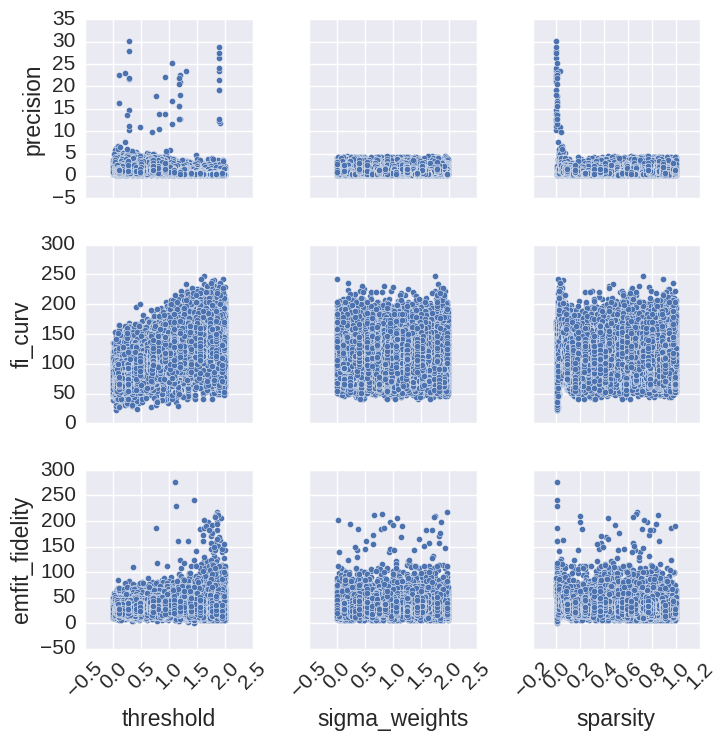

In [30]:
# Cross-correlation plots
g = sns.pairplot(
    df_fits_filtered_full,
    x_vars=parameter_names_sorted,
    y_vars=['precision', 'fi_curv', 'emfit_fidelity']
)
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

## Quantize and do some plots

In [31]:
nQuantiles = 51

df_quantized, param_qbins, param_qbins_middle = df_add_quantize_parameters(
    df_fits_filtered, parameter_names_sorted, nQuantiles)

## 2D plot M/ratio_conj

In [32]:
def plot_mean_std_df(df, x_col, y_col, param_qbins_middle, xlabel=None, ylabel=None, ax=None):
    df_mean = df.groupby(x_col + "_qi").mean()
    df_std = df.groupby(x_col + "_qi").std()
    
    return utils.plot_mean_std_area(df_mean[x_col], #param_qbins_middle[x_col], 
                                    df_mean[y_col],
                                    df_std[y_col],
                                    xlabel=xlabel,
                                    ylabel=ylabel,
                                    ax_handle=ax,
                                    label=y_col
                                   )

In [33]:
def compute_spline_interpolation(df, interpolate_column, x_col='', y_col='', kx=3, ky=3, s=None):
    
    if interpolate_column + "_std" in df:
        w = 1./df[interpolate_column + "_std"]
    else:
        w = None
        
    return spint.SmoothBivariateSpline(df[x_col], df[y_col], df[interpolate_column], w=w, kx=kx, ky=ky, s=s)

def pcolor_2d_interpolated(df, target_column, x_col='M', y_col='rc_scale', x_int_space=None, y_int_space=None,
                           title='', vmin=None, vmax=None, cmap='RdBu_r'):
    if x_int_space is None:
        x_int_space = np.sort(df[x_col].unique())
    if y_int_space is None:
        y_int_space = np.sort(df[y_col].unique())

    spline_int = compute_spline_interpolation(df, target_column, 
                                              x_col=x_col, y_col=y_col)
    return utils.pcolor_2d_data(spline_int(x_int_space, y_int_space),
                                x=x_int_space, 
                                y=y_int_space, 
                                xlabel=x_col, 
                                ylabel=y_col, 
                                title=title,
                                ticks_interpolate=15,
                                vmin=vmin,
                                vmax=vmax,
                                log_scale=False, 
                                cmap=cmap
                               )

In [34]:
df_avgstd = df_quantized.groupby(parameter_names_sorted, as_index=False).agg(('mean', 'std')).reset_index()
df_avgstd.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df_avgstd.columns.values]
df_avgstd.columns = [s.split('_mean')[0] for s in df_avgstd.columns]


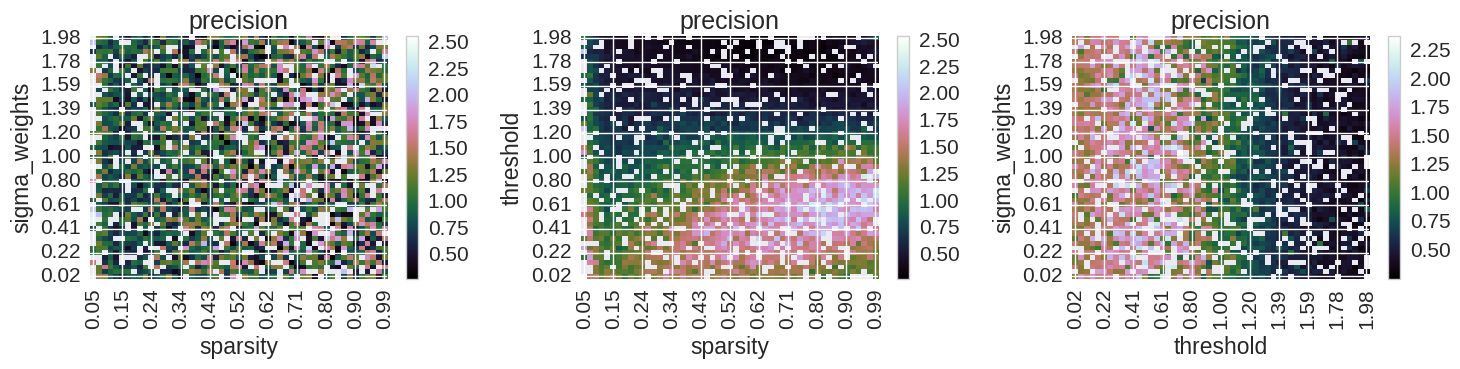

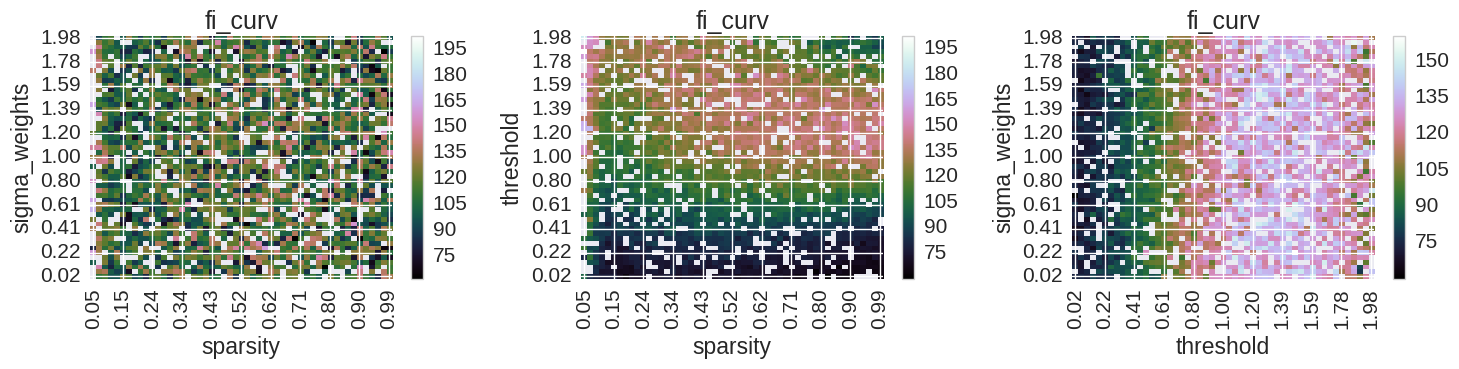

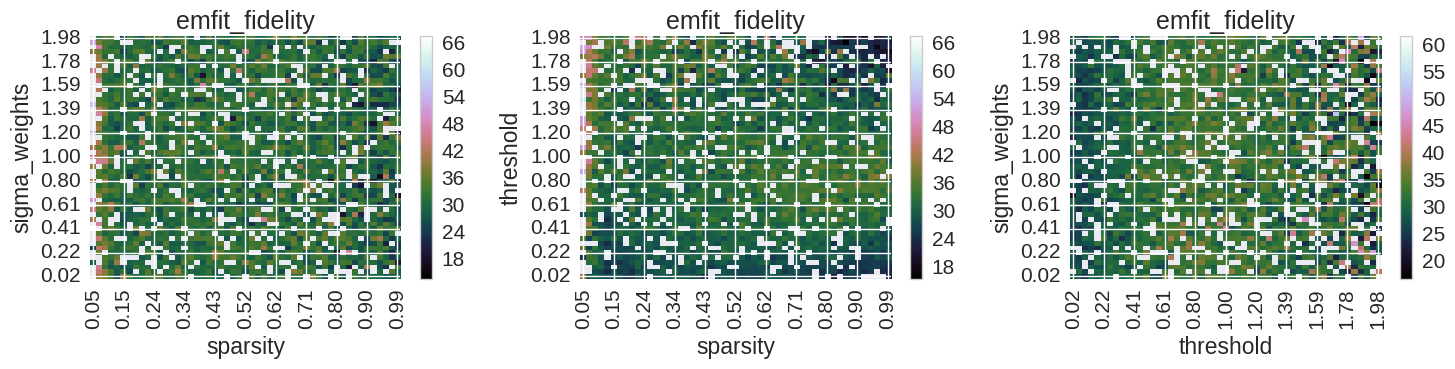

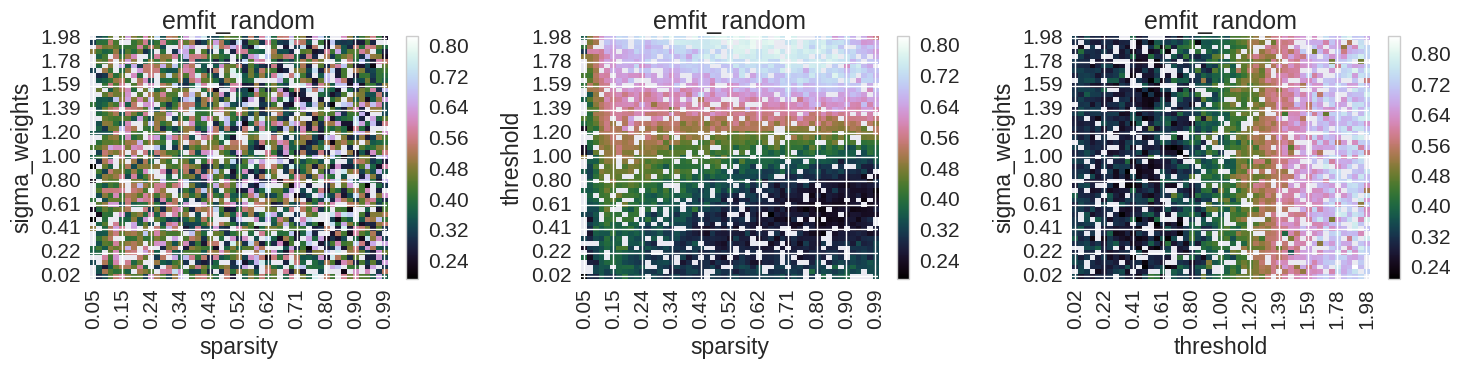

In [35]:
values = ['precision', 'fi_curv', 'emfit_fidelity', 'emfit_random']

for value in values:
    f, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i, params in enumerate([
            ('sparsity', 'sigma_weights'), ('sparsity', 'threshold'), ('threshold', 'sigma_weights')]):
        data_pivot = df_avgstd.pivot_table(index="{}_qi".format(params[0]), columns="{}_qi".format(params[1]), 
                                           values=value).as_matrix()
        with sns.axes_style('whitegrid'):
            utils.pcolor_2d_data(data_pivot, x=param_qbins_middle[params[0]], y=param_qbins_middle[params[1]], 
                                 ticks_interpolate=11, cmap='cubehelix', xlabel=params[0], ylabel=params[1], 
                                 title=value, ax_handle=axes[i])

    f.tight_layout()
    # dataio.save_current_figure("fisher_fidelity_ratio_deviation_2d_white.pdf")

## sigma_weight / lambda has no effect.

This is because we normalise, which means I'm a bit silly:

$$
  x_i \sim Exp(\lambda), i=1, \ldots, N \\
  y_i = \frac{x_i}{\sum_i^N x_i}
$$

$$
  E[x_i] = \lambda \\
  E[y_i] = E\left[\frac{x_i}{\sum_i^N x_i}\right] = \frac{E[x_i]}{E[\sum_i^N x_i]}
$$

$$E[\sum_i^N x_i] = \sum_i^N E[x_i] = N \lambda $$

$$ \Rightarrow E[y_i] = \frac{\lambda}{N \lambda} = \frac{1}{N} $$

In [36]:
# Verifying that lambda is useless
M = 100
lambd = 10

samples = np.random.exponential(lambd, size=(1000, M))
print np.mean(samples), np.std(samples)
print np.mean(np.mean(samples, axis=1)), np.std(np.mean(samples, axis=1))
print np.mean(np.std(samples, axis=1)), np.std(np.std(samples, axis=1))

samples /= np.sum(samples, axis=-1)[:, np.newaxis]

print np.mean(samples), np.std(samples)
print np.mean(np.mean(samples, axis=1)), np.std(np.mean(samples, axis=1))
print np.mean(np.std(samples, axis=1)), np.std(np.std(samples, axis=1))

print "Lambda:", lambd
print "1/M:", 1./M

9.98991554898 9.98426106297
9.98991554898 1.02406676769
9.83141656667 1.40712633462
0.01 0.00988238165285
0.01 2.46061826838e-18
0.00983759161187 0.000939818285989
Lambda: 10
1/M: 0.01


** Question is now, do we remove the normalization and entangle $\lambda$ back with $\theta$ ??**

Alternatives:
1. We explicitly remove the $\lambda$, and explain that we just sample weights to be $\frac{1}{N_{lower}}$. I think this kinda means having the same output?
1. We change it so that Sparsity should be dependent on number of lower layer units.
1. Do we want weight of different scales somehow? Maybe never?



In [37]:
nQuantiles = 35

df_quantized_nolambda, param_qbins, param_qbins_middle = df_add_quantize_parameters(
    df_fits_filtered_full, ['sparsity', 'threshold'], nQuantiles)

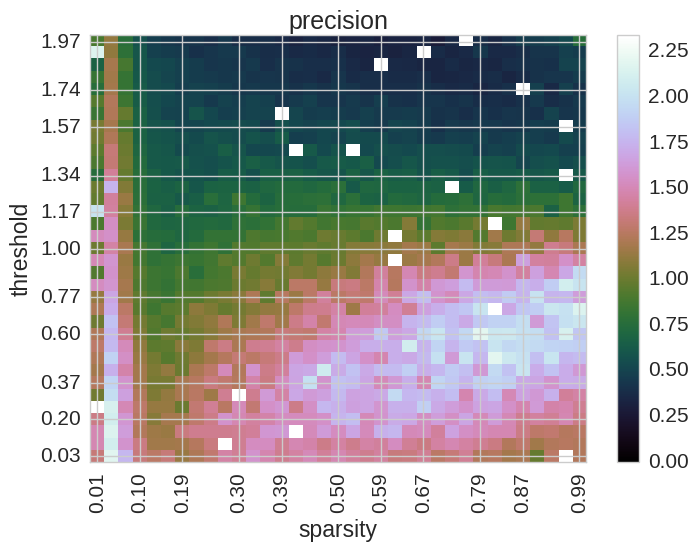

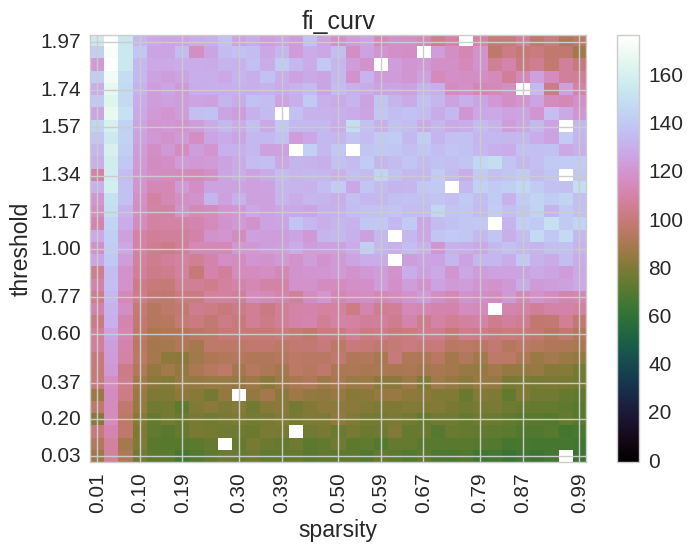

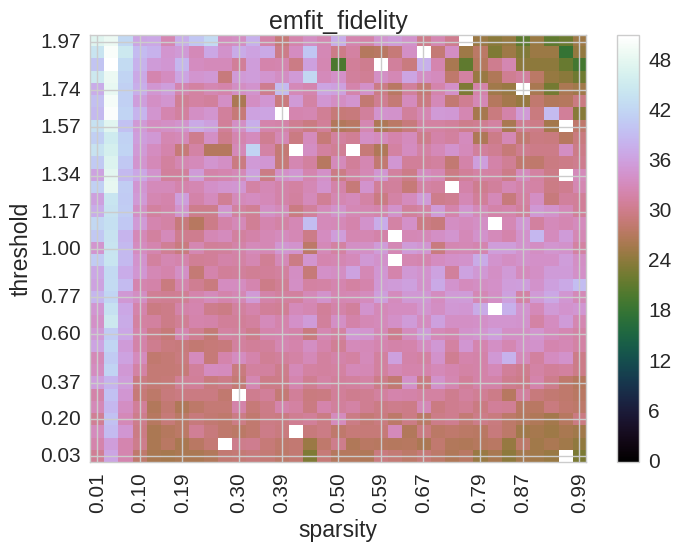

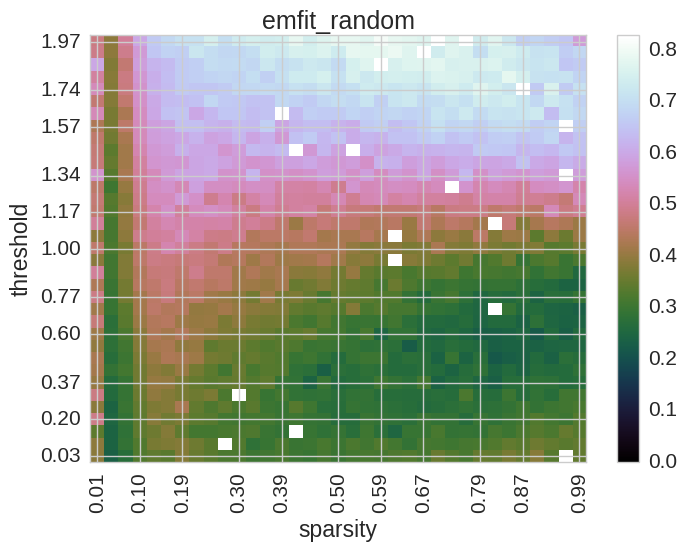

In [38]:
values = ['precision', 'fi_curv', 'emfit_fidelity', 'emfit_random']

for value in values:
    params = ('sparsity', 'threshold')
    data_pivot = df_quantized_nolambda.pivot_table(
        index="{}_qi".format(params[0]), columns="{}_qi".format(params[1]), values=value).as_matrix()
    with sns.axes_style('whitegrid'):
        utils.pcolor_2d_data(data_pivot, x=param_qbins_middle[params[0]], y=param_qbins_middle[params[1]], 
                             ticks_interpolate=11, cmap='cubehelix', xlabel=params[0], ylabel=params[1], 
                             title=value, vmin=0)

    f.tight_layout()
    # dataio.save_current_figure("fisher_fidelity_ratio_deviation_2d_white.pdf")

# Something funny is happening for low sparsity

Maybe we have two regimes?

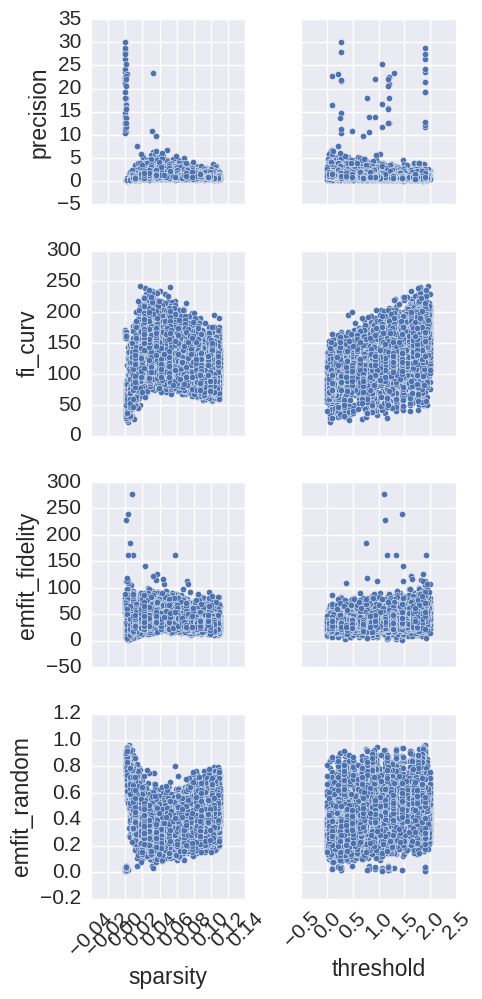

In [39]:
df_low_sparsity = df_fits_filtered_full[df_fits_filtered_full.sparsity < 0.11]

g = sns.pairplot(
    df_low_sparsity,
    x_vars=['sparsity', 'threshold'],
    y_vars=['precision', 'fi_curv', 'emfit_fidelity', 'emfit_random']
)
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

In [40]:
nQuantiles = 21

df_low_sparsity_quant, param_qbins_lowsparse, param_qbins_middle_lowsparse = df_add_quantize_parameters(
    df_low_sparsity, ['sparsity', 'threshold'], nQuantiles)

/nfs/nhome/live/lmatthey/Applications/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


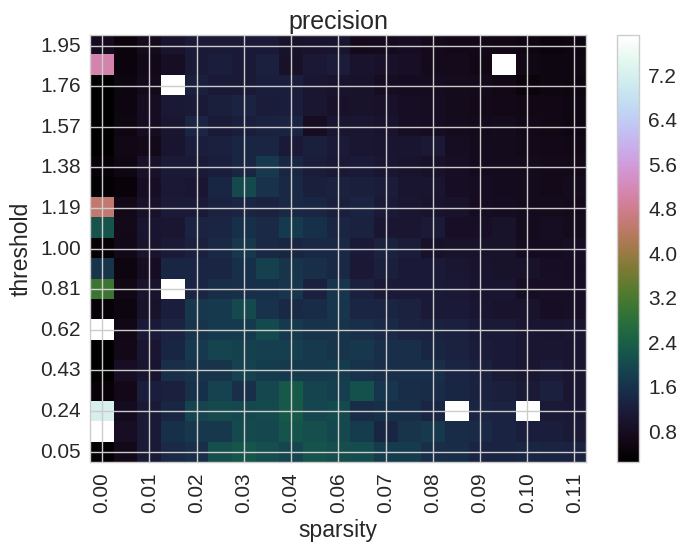

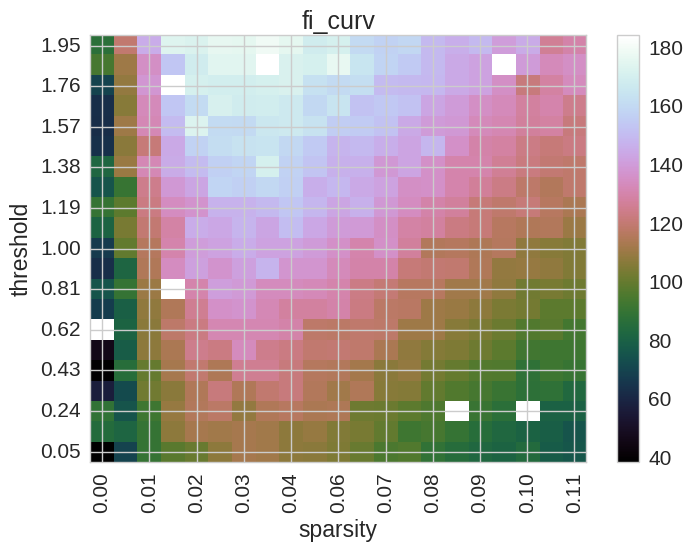

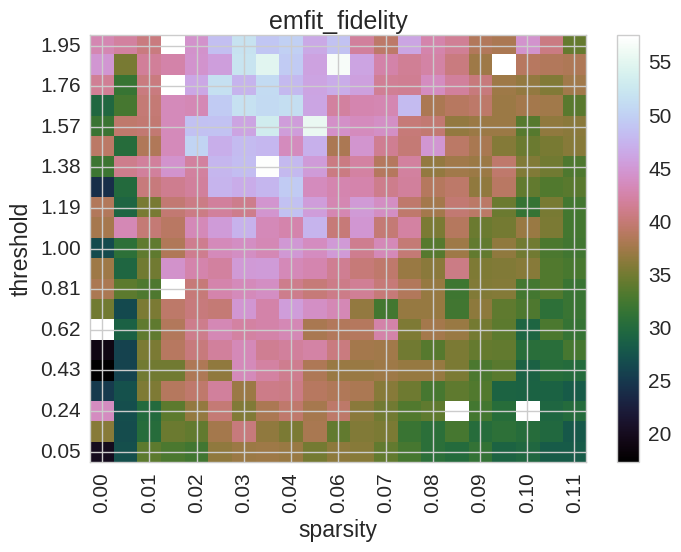

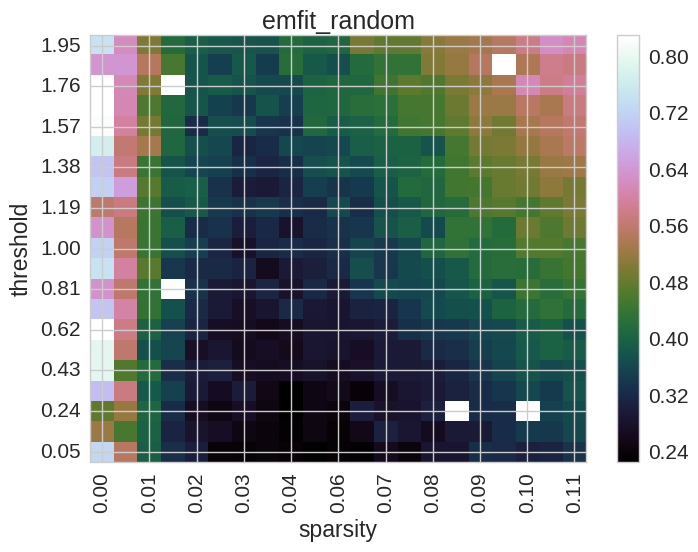

In [41]:
values = ['precision', 'fi_curv', 'emfit_fidelity', 'emfit_random']

for value in values:
    params = ('sparsity', 'threshold')
    data_pivot = df_low_sparsity_quant.pivot_table(
        index="{}_qi".format(params[0]), columns="{}_qi".format(params[1]), values=value).as_matrix()
    with sns.axes_style('whitegrid'):
        utils.pcolor_2d_data(data_pivot, 
                             x=param_qbins_middle_lowsparse[params[0]], 
                             y=param_qbins_middle_lowsparse[params[1]], 
                             ticks_interpolate=11, 
                             cmap='cubehelix', 
                             xlabel=params[0], 
                             ylabel=params[1], 
                             title=value)

    f.tight_layout()
    # dataio.save_current_figure("fisher_fidelity_ratio_deviation_2d_white.pdf")

## ==> Will run a new sweep in [this notebook](notebook_hierarchical_weights_2try_280818.ipynb) for low-sparsity.

# Comparison of metrics

In [42]:
def bars_fisherinfo_comparison(values_bars, 
                               values_bars_std, 
                               values_names, 
                               ax=None, 
                               mem_fidelity_bar_factor=2.0,
                               mem_fidelity_show_main=True):
    color_gen = sns.color_palette(palette='muted', n_colors=len(values_bars))
    # set_colormap = plt.cm.cubehelix

    bars_indices = np.arange(values_bars.size)
    width = 0.7
    if mem_fidelity_bar_factor > 1.:
        zorders = {'main': (2, 3), 'factor': (1, 3)}
        factors = {'main': 1, 'factor': mem_fidelity_bar_factor}
    else:
        zorders = {'main': (1, 2), 'factor': (2, 3)}
        factors = {'main': 1, 'factor': mem_fidelity_bar_factor}

    ## Plot all as bars
    if ax is None:
        f, ax = plt.subplots(figsize=(12,6))
        
    # Add the memory fidelity multiplied by some factor
    if mem_fidelity_show_main:
        ax.bar(bars_indices[0],
               factors['main']*values_bars[0], 
               width=width, 
               color=color_gen[0], 
               zorder=zorders['main'][0])
        ax.errorbar(bars_indices[0] + width/2., 
                    factors['main']*values_bars[0], 
                    yerr=factors['main']*values_bars_std[0], 
                    ecolor='k', 
                    capsize=20, 
                    capthick=2, 
                    linewidth=2,
                    zorder=zorders['main'][1]
                   )

    if mem_fidelity_bar_factor:
        ax.bar(bars_indices[0], 
               factors['factor']*values_bars[0], 
               width=width, 
               color=color_gen[0], 
               alpha=0.7, 
               hatch='/', 
               linestyle='dashed',
               zorder=zorders['factor'][0]
               )
        ax.errorbar(bars_indices[0] + width/2., 
                     factors['factor']*values_bars[0], 
                     yerr=factors['factor']*values_bars_std[0], 
                     ecolor='k', 
                     alpha=0.4, 
                     capsize=20, capthick=2, 
                     linewidth=2, linestyle='--', fmt="none",
                     zorder=zorders['factor'][1]
                    )
        
    for bar_i in xrange(1, values_bars.size):
        ax.bar(bars_indices[bar_i], 
               values_bars[bar_i], 
               width=width, 
               color=color_gen[bar_i], 
               zorder=2)
        ax.errorbar(bars_indices[bar_i] + width/2., 
                    values_bars[bar_i], 
                    yerr=values_bars_std[bar_i], 
                    ecolor='k', 
                    capsize=20, 
                    capthick=2, 
                    linewidth=2, 
                    zorder=3)


    ax.set_xticks(bars_indices + width/2.)
    ax.set_xticklabels(values_names)
    ax.set_xlim((-0.2, bars_indices.size))
    plt.tight_layout()
    
    return ax

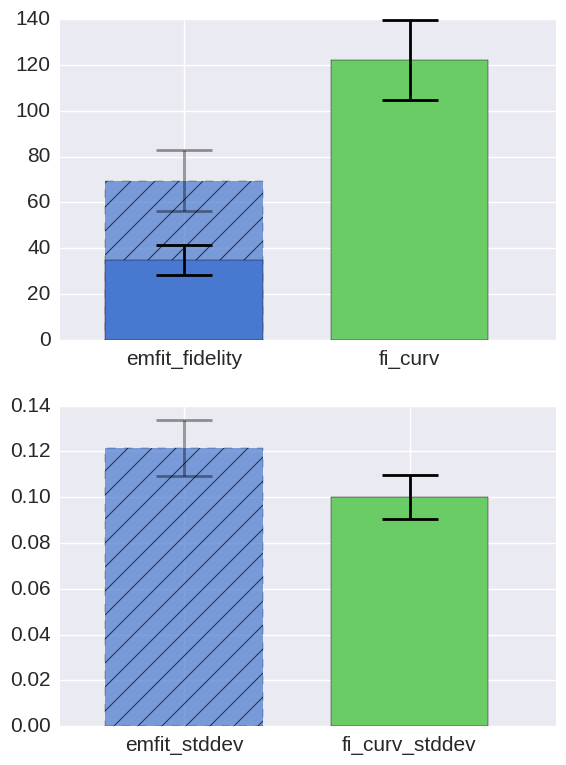

In [43]:
target_params = {
    'sparsity': 0.999,
    'threshold': 1.
}
data_M = filter_quantized_param(df_avgstd, target_params, param_qbins).mean()

f, axes = plt.subplots(2, 1, figsize=(6, 8))

values_names = ["emfit_fidelity", "fi_curv"]
bars_fisherinfo_comparison(np.array([data_M[k] for k in values_names]), 
                           np.array([data_M[k + "_std"] for k in values_names]), 
                           values_names,
                           ax=axes[0]
                          )

values_names = ["emfit_stddev", "fi_curv_stddev"]
bars_fisherinfo_comparison(np.array([data_M[k] for k in values_names]), 
                           np.array([data_M[k + "_std"] for k in values_names]), 
                           values_names, 
                           mem_fidelity_bar_factor=0.5**0.5,
                           mem_fidelity_show_main=False,
                           ax=axes[1]
                          )


# Playing with hierarchical network

In [44]:
arguments_dict = dict(
    action_to_do='launcher_do_simple_run',
    inference_method='none',
    code_type='hierarchical',
    M=100,
    ratio_hierarchical=0.5,
    sparsity=1.,
    threshold=0.8,
    N=500,
    num_samples=50,
    T=1,
    num_repetitions=5,
    renormalize_sigma=None,
    autoset_parameters=None,
    ratio_conj=0.1,
    sigmax=0.2,
    sigmay=0.000001,
    sigma_baseline=0.0,
    sigma_output=0.0,
    selection_num_samples=1,
    selection_method='last',
    slice_width=0.07,
    burn_samples=100,
    enforce_min_distance=0.017,
    specific_stimuli_random_centers=None,
    stimuli_generation='random',
    stimuli_generation_recall='random',
    experiment_data_dir=os.path.normpath(os.path.join(os.environ['WORKDIR_DROP'], '../../experimental_data')),
)
with io.capture_output(display=False, stdout=True) as captured:
    experiment_launcher = ExperimentLauncher(run=True, arguments_dict=arguments_dict)
    sampler = experiment_launcher.all_vars['sampler']
    network = sampler.random_network


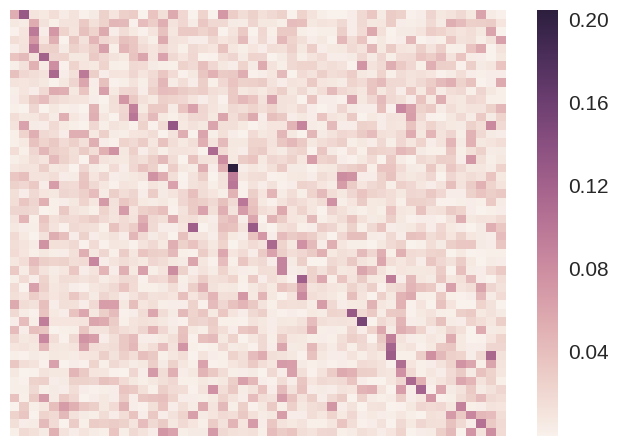

In [45]:
# Weights, sorted by top input neuron
weights = network.A_sampling
sns.heatmap(weights[np.argsort(np.argmax(weights, axis=-1))], xticklabels=False, yticklabels=False)

Average number of input neurons:
6.46


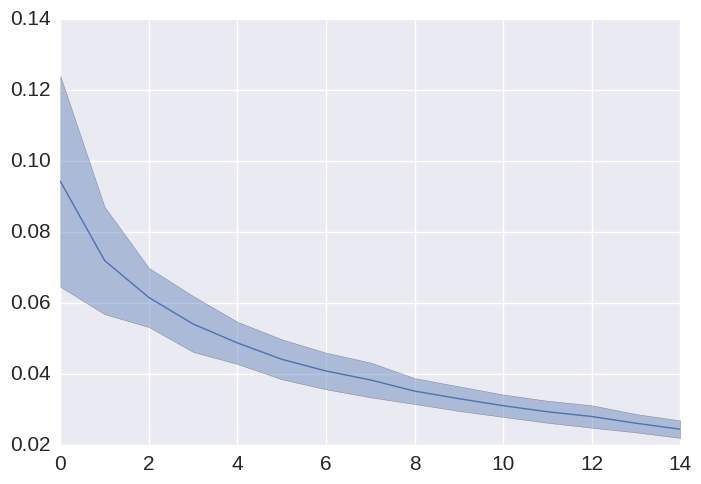

In [46]:
# Average weights coming in, sorted.
sorted_weights = np.sort(weights, axis=-1)[:, -15:]
weights_mean = np.mean(sorted_weights, axis=0)[::-1]
weights_std = np.std(sorted_weights, axis=0)[::-1]
utils.plot_mean_std_area(np.arange(weights_mean.size), weights_mean, weights_std)

print "Average number of input neurons:"
print np.mean(np.sum(weights > (np.mean(weights) + 1*np.std(weights)), axis=1))

(0.25277972596667264, 0.038979253875587844)


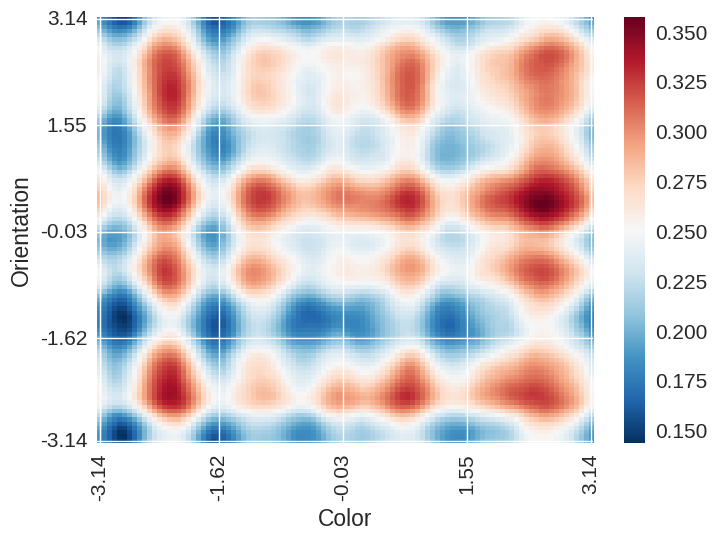

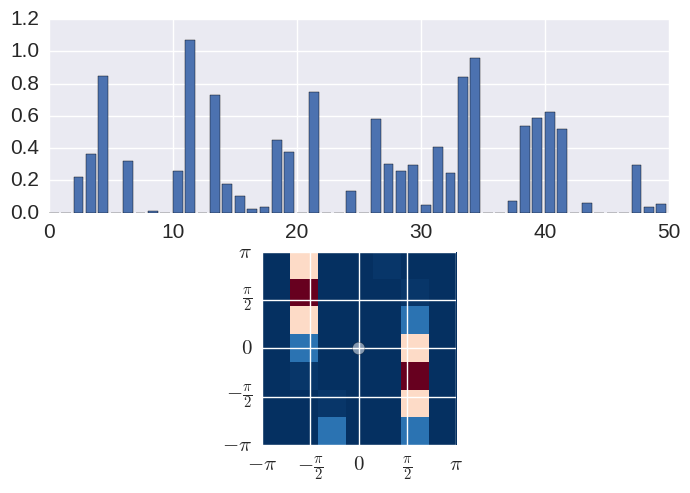

In [47]:
network.plot_mean_activity()
network.plot_network_activity()

In [57]:
# Precision as a function of the angle
df_avgstd = sampler.estimate_precision_per_angle(fit_mixture_model=False, num_repetitions=100)

[100%] 4s                                                                     


(-3.141592653589793, 3.141592653589793)

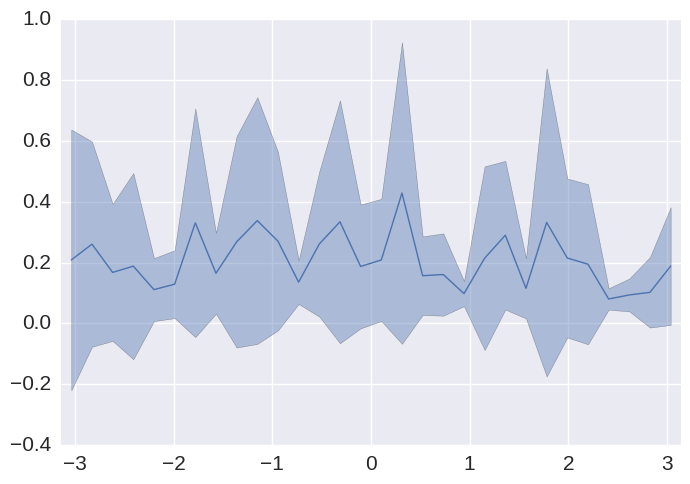

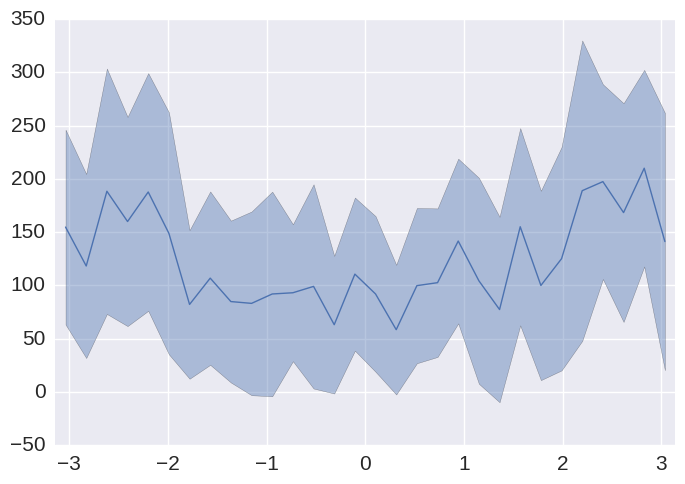

In [61]:
ax1 = utils.plot_mean_std_area(
    df_avgstd['angle_middle'], df_avgstd['precisions_stddev'], df_avgstd['precisions_stddev_std'])
ax2 = utils.plot_mean_std_area(
    df_avgstd['angle_middle'], df_avgstd['precisions'], df_avgstd['precisions_std'])

ax1.set_xlim((-np.pi, np.pi))
ax2.set_xlim((-np.pi, np.pi))

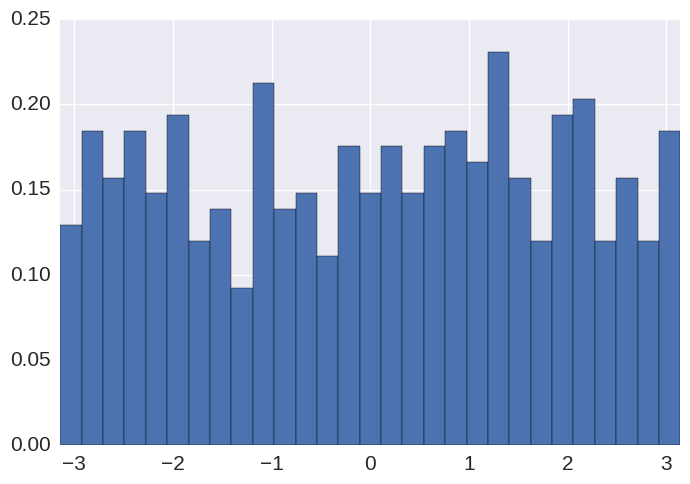

In [65]:
utils.hist_angular_data(sampler.get_target_angles(), bins=30)